In [1]:
from backend import workflow
from imagen_pytorch import Unet, Imagen, ImagenTrainer
import torch
from IPython.display import clear_output

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-15 15:48:33.855838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 15:48:33.993023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744724914.046889     548 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744724914.060802     548 cuda_blas.cc:1418] Unable to register cuBLAS

In [2]:
source_directory = 'datasets/dimensi0n/imagenet-256/zebra'
using_checkpoint = 'checkpoints/a_model.pt'

dataloader = workflow(source_directory)

Loading T5 Tokenizer and Encoder Model (t5-large)...
T5 models loaded.


In [3]:
# Imagen & Unets

unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True)
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    unets = (unet1, unet2),
    text_encoder_name = 't5-large',
    image_sizes = (64, 256),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [10]:
#Preparing imagen and trainer

imagen.train()
trainer = ImagenTrainer(imagen).cuda()
trainer.train()
clear_output()

In [11]:
# Load the model

trainer.load(using_checkpoint)
clear_output()

In [ ]:
# Code for running the training

num_epochs = 240
unet_toTrain = 2    # Can't train both unets at the same time, need to save checkpoint and re-initiate the trainer when changing unets  z

#Training in epochs, each unet is trained once in each epoch
losses = 0
for epoch in range(num_epochs):
    clear_output()
    print(f"Epoch {epoch+1}/{num_epochs}, Training UNet {unet_toTrain}, Prev epoch avg loss: {losses/len(dataloader)}")
    losses = 0
    for images_batch, text_embeds_batch in dataloader:
        if images_batch.numel() == 0: continue # Skip if batch is empty after filtering

        images_batch = images_batch.cuda()
        text_embeds_batch = text_embeds_batch.cuda()

        loss = trainer(images_batch, text_embeds = text_embeds_batch, unet_number = unet_toTrain)
        losses += loss
        trainer.update(unet_number = unet_toTrain)
        print(f"Loss: {loss}")

Epoch 9/240, Training UNet 2
Loss: 0.01747814193367958
Loss: 0.020625341683626175
Loss: 0.010141652077436447
Loss: 0.01355886459350586
Loss: 0.01862369477748871
Loss: 0.04803543910384178
Loss: 0.025895215570926666
Loss: 0.010252408683300018
Loss: 0.04153301566839218
Loss: 0.03113638050854206
Loss: 0.010176163166761398
Loss: 0.02813173457980156
Loss: 0.019852040335536003
Loss: 0.01394263468682766
Loss: 0.019692622125148773
Loss: 0.023024816066026688
Loss: 0.03392767906188965
Loss: 0.02201032266020775
Loss: 0.03542404994368553
Loss: 0.037207700312137604


In [8]:
# Save the model
trainer.save(using_checkpoint)

checkpoint saved to checkpoints/a_model.pt


sampling loop time step: 100%|██████████| 1000/1000 [01:29<00:00, 11.19it/s]
2it [02:53, 86.78s/it]


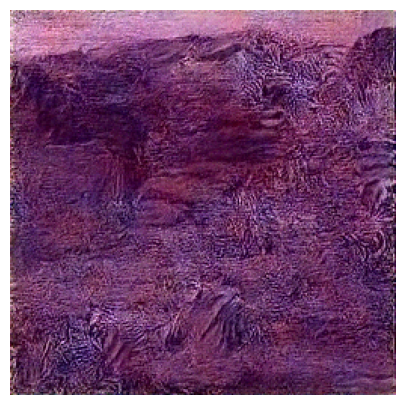

In [9]:
# Generate images

images = trainer.sample(texts = [
    'two zebras in a field'
], cond_scale = 3.)

# Code for displaying the generated images

import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Move images tensor to CPU and detach from gradient computation
images_cpu = images.cpu().detach()

# If your images are normalized to [-1, 1], denormalize them to [0, 1]
# images_cpu = (images_cpu + 1) / 2 # Uncomment if you used transforms.Normalize(...)

# Clamp values to [0, 1] just in case
images_cpu = torch.clamp(images_cpu, 0, 1)

# Make a grid of images (rows = number of samples)
grid = vutils.make_grid(images_cpu, nrow=len(images_cpu), padding=2, normalize=False) # normalize=False as we clamped

# Convert grid tensor to numpy array and transpose dimensions for matplotlib
# (C, H, W) -> (H, W, C)
np_grid = grid.permute(1, 2, 0).numpy()

# Display the grid
plt.figure(figsize=(10, 5))
plt.imshow(np_grid)
plt.axis('off')
plt.show()